We'll be predicting breast cancer diagnoses based on 10 attributes, rated by a doctor. First, we'll read in the data and do some cleaning.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from sklearn.model_selection import cross_val_score
%matplotlib inline

cancer = pd.read_csv("breast-cancer-wisconsin.csv",header=None)
cancer.columns=['id','clump_thickness','cell_size_uniformity','cell_shape_uniformity','marginal_adhesion','single_epithelial_cell_size','bare_nuclei','bland_chromatin','normal_nucleoli','mitoses','class']

In [9]:
cancer.head()

,id,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [19]:
# let's drop ID, since that's not a useful feature.
cancer = cancer.drop('id',axis=1)

# Converting class to a simpler binary
cancer['class'] = np.where(cancer['class'] == 2,0,1)

# Getting rid of ? in bare_nuclei field, converting to number
cancer['bare_nuclei'] = cancer['bare_nuclei'].replace('?', None)
cancer['bare_nuclei'] = pd.to_numeric(cancer['bare_nuclei'])

print(cancer.shape)
cancer.isnull().sum()

(699, 10)


clump_thickness                0
cell_size_uniformity           0
cell_shape_uniformity          0
marginal_adhesion              0
single_epithelial_cell_size    0
bare_nuclei                    0
bland_chromatin                0
normal_nucleoli                0
mitoses                        0
class                          0
dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\_kernel_base.py:514: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:1533: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\conto

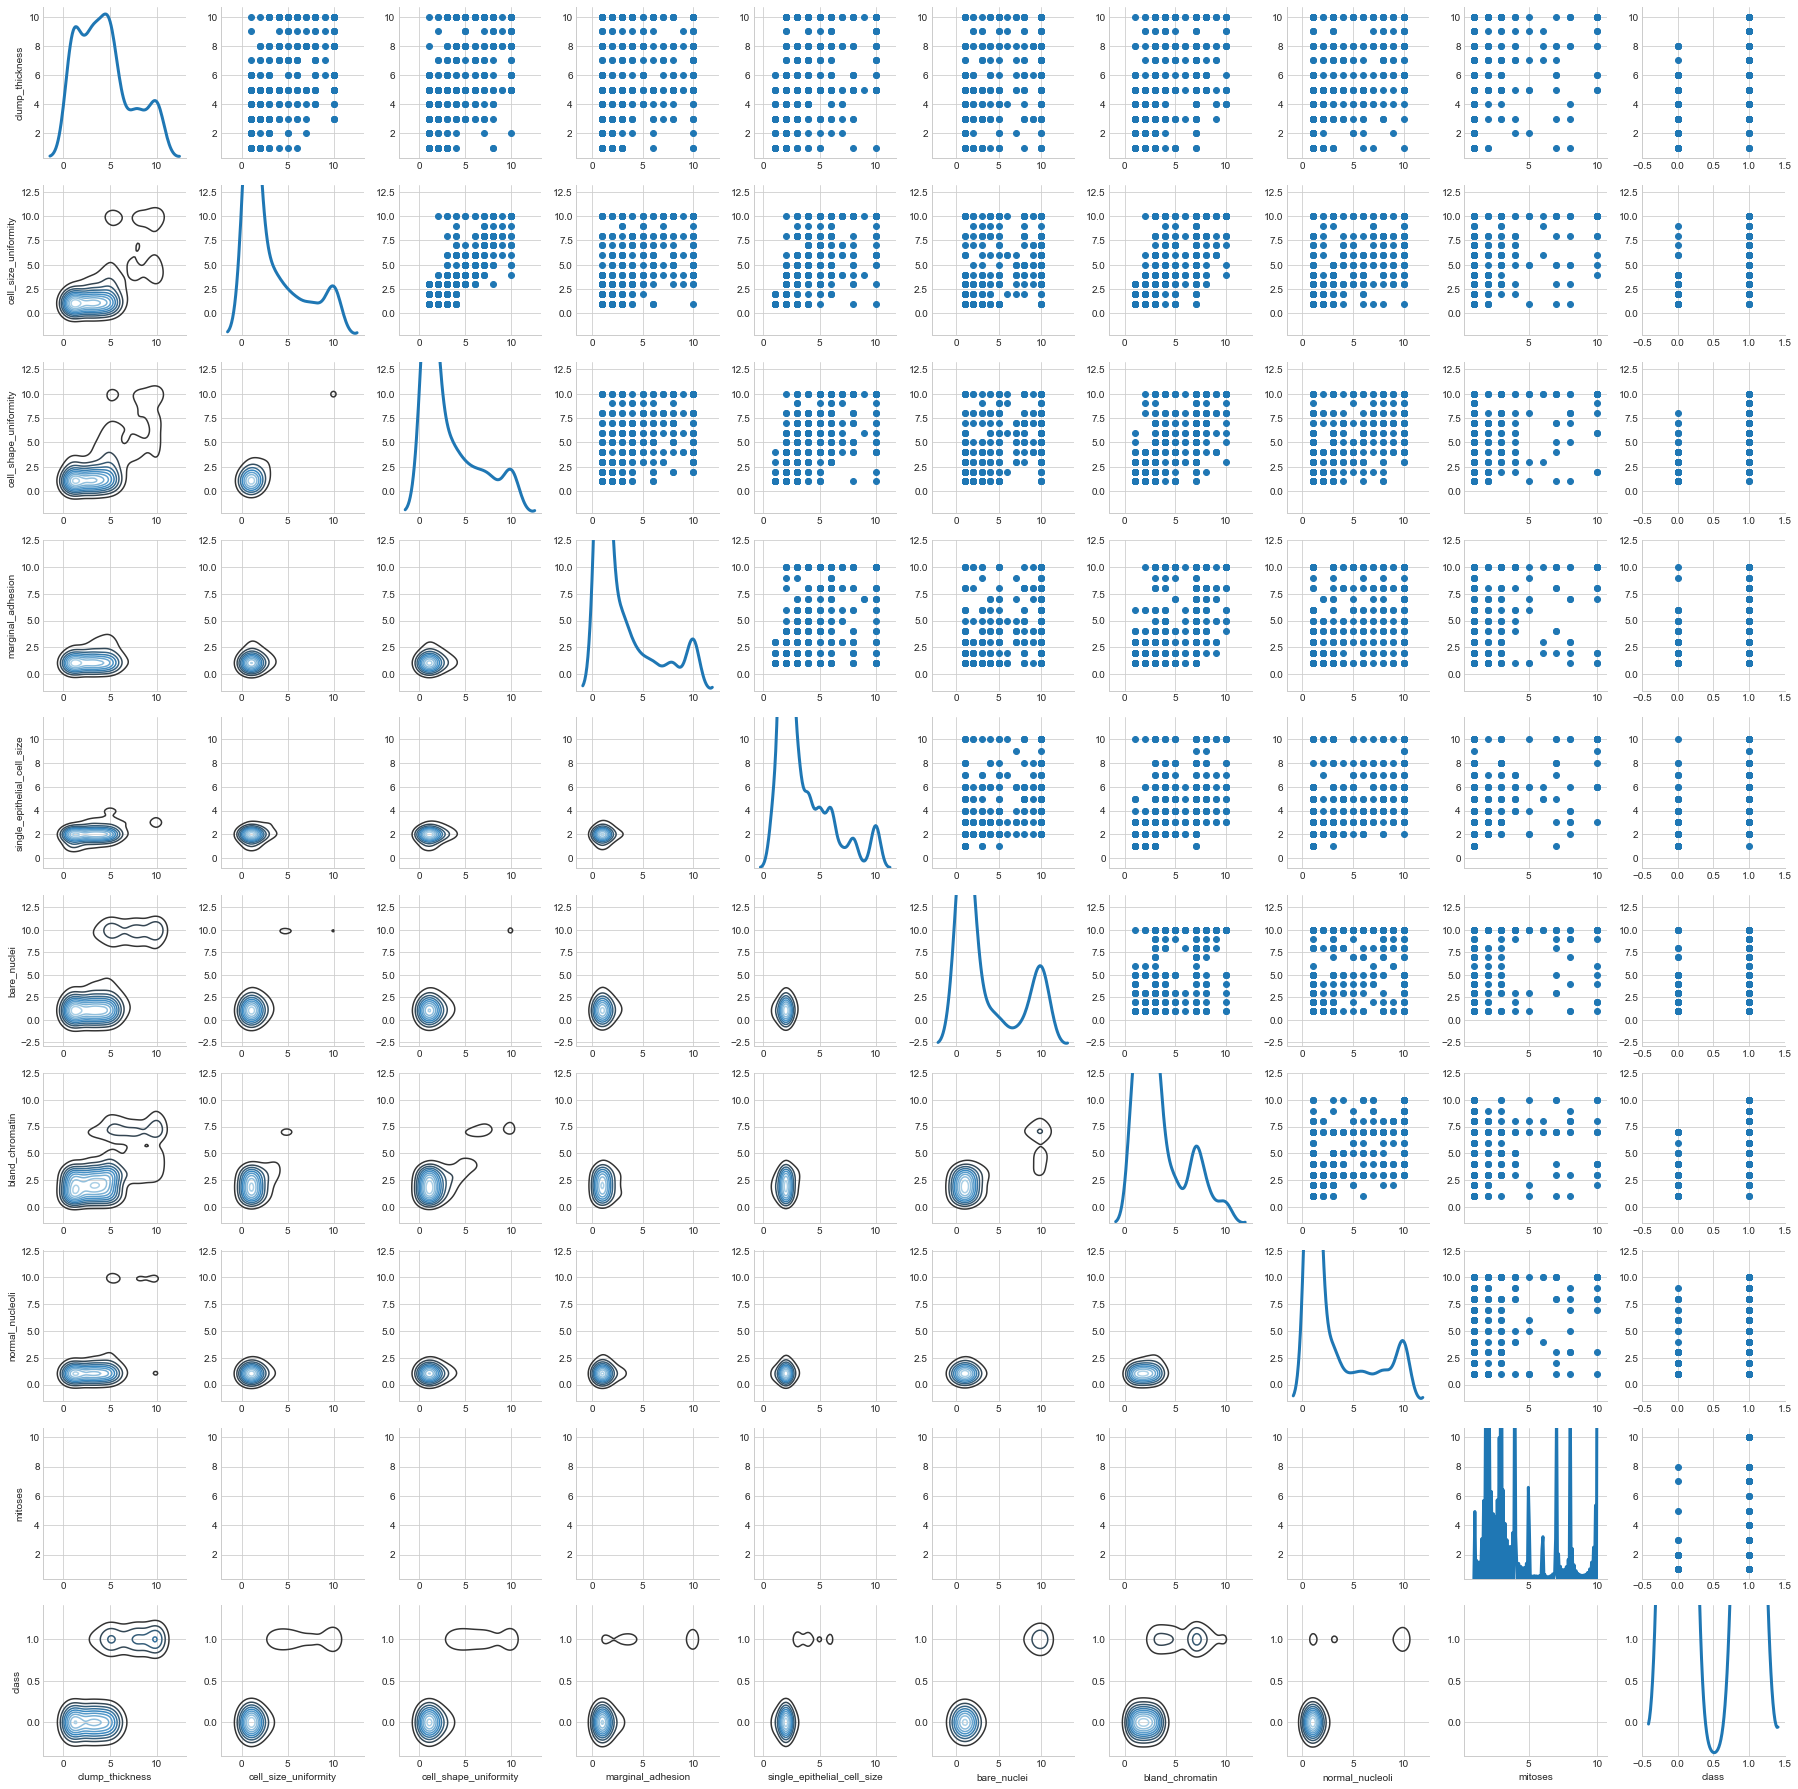

In [106]:
# Plotting the variables to get some insights into their relationships with one another
sns.set_style("whitegrid")
h = sns.PairGrid(cancer)
h.map_lower(sns.kdeplot, cmap="Blues_d")
h.map_upper(plt.scatter)
h.map_diag(sns.kdeplot, lw=3)

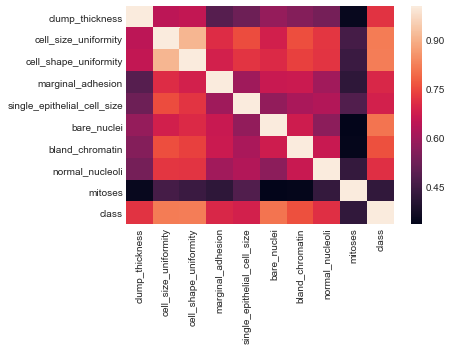

In [46]:
correlations = cancer.corr()
sns.heatmap(correlations)
plt.show()

Note that the variables seem to be somewhat independent of one another, and their relationships to the outcome variable are not exactly clear. A Naive Bayes classifier might be a good place to start, since these models are simple, interpretable, and provide decent performance in many real life situations.

In [42]:
X = cancer.drop(['class'],axis=1)
Y = cancer['class']

In [44]:
from sklearn.naive_bayes import MultinomialNB
nbc = MultinomialNB()

nbc.fit(X,Y)

nb_accuracies = cross_val_score(nbc,X,Y)
print('Cross Validation Accuracies: /n')
print(nb_accuracies)
print('Avg Accuracy: {}'.format(nb_accuracies.mean()))

Cross Validation Accuracies: /n
[ 0.83760684  0.86695279  0.9137931 ]
Avg Accuracy: 0.8727842435848947


Our model performs pretty well. We could perhaps reduce the feature set to make the variables as independent as possible. Let's give it a shot by performing PCA on the feature set.

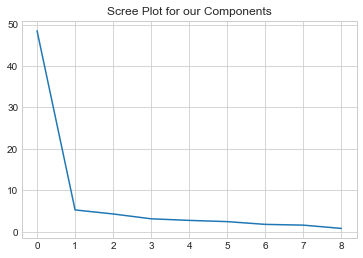

Percent of variance explained by component 
 [0.68762392042238296, 0.074648162797918319, 0.060823507372810816, 0.0442875130574222, 0.03880807800241369, 0.034647258760680727, 0.025177804233416697, 0.022589184291348818, 0.011394571061605879]
Eigenvalues: 

[48.515500745131227, 5.2668222996379583, 4.2914198148523912, 3.1247180456106705, 2.7381149511010019, 2.4445471693131693, 1.7764271191973127, 1.5937863049407184, 0.8039471932422263]


In [56]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components=9)
pca_feat = X

pca_feat = sklearn_pca.fit_transform(X)
var_ratios = sorted(list(sklearn_pca.explained_variance_ratio_),reverse=True)
component_variances = sorted(list(sklearn_pca.explained_variance_),reverse=True)

sorted_eigenvals = sorted(component_variances,reverse=True)
plt.plot(sorted_eigenvals)
plt.title("Scree Plot for our Components")
plt.show()

print('Percent of variance explained by component \n',var_ratios)
print('Eigenvalues: \n')
print(component_variances)

By the rule of thumb of including PCA components with an eigenvalue >=1, we'd include all but the last PCA component, for a total of 8. Let's see how this performs.

In [66]:
pca_features

,0,1,2,3,4,5,6,7
0,-4.437523,0.140152,-1.739688,0.126937,-0.834350,-0.611043,-1.049533,0.091579
1,4.842940,-4.875919,0.861617,0.725503,1.049574,2.162763,0.509566,3.076861
2,-4.594002,-0.603916,0.027812,-0.300584,0.130117,-0.249241,-0.944590,-0.110994
3,5.145849,3.458943,-2.032486,-1.789870,3.263012,-0.794903,3.311328,-1.371951
4,-4.072230,-0.037962,0.055371,0.906532,-1.687082,-0.906128,-0.640079,0.213506
5,15.048932,-0.494624,0.608806,0.955401,1.728634,-2.463379,0.059455,0.742590
6,-1.672482,-6.933980,2.222819,-2.789209,2.178125,1.664641,-0.466582,-0.440388
7,-4.939692,0.392510,0.749314,0.114885,0.766577,-0.495854,-0.632656,-0.427404
8,-5.422234,0.850633,0.770715,0.620942,-0.623072,3.382304,-0.498365,-2.070546
9,-4.623556,0.385364,-1.012204,0.372066,-0.152169,-0.157662,-0.051225,0.039523


In [65]:
# Create df with just the PCA components we want
pca_features = pd.DataFrame(pca_feat)
pca_features = pca_features.drop(8,axis=1)

# Rerunning the model
nbc.fit(X,Y)

nb_accuracies = cross_val_score(nbc,pca_features,Y)
print('Cross Validation Accuracies: /n')
print(nb_accuracies)
print('Avg Accuracy: {}'.format(nb_accuracies.mean()))a

ValueError: Input X must be non-negative

Let's try instead a few different flavors of logistic regression.

In [73]:
from sklearn import linear_model
lr= linear_model.LogisticRegression()

lr.fit(X,Y)

# Run cross validation
lr_accuracies = cross_val_score(lr,X,Y)
print('Cross Validation Accuracies: /n')
print(lr_accuracies)
print('Avg Accuracy: {}'.format(lr_accuracies.mean()))

Cross Validation Accuracies: /n
[ 0.92307692  0.96137339  0.99137931]
Avg Accuracy: 0.9586098746598969


This performs better than our Naive Bayes classifier, but I think it can be improved even more with a gridsearch for the exact optimal regularization parameters.

In [114]:
# Setting up the parameters we want to try
params = {'C': [0.001,0.01,0.1,1, 10, 100, 1000,100000,1000000],'penalty':['l1','l2']}

nlr = linear_model.LogisticRegression()

from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(nlr, params,scoring='accuracy')
clf.fit(X,Y)
#clf.cv_results_
#clf.best_params_

In [117]:
nlr_best = linear_model.LogisticRegression(**clf.best_params_)

In [119]:
clf_accuracies = cross_val_score(nlr_best,X,Y)
print('Cross Validation Accuracies: /n')
print(clf_accuracies)
print('Avg Accuracy: {}'.format(clf_accuracies.mean()))

Cross Validation Accuracies: /n
[ 0.93589744  0.96566524  0.99137931]
Avg Accuracy: 0.964313994097922


In [96]:
clf.get_params()

{'cv': None,
 'error_score': 'raise',
 'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'ovr',
 'estimator__n_jobs': 1,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'liblinear',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'fit_params': None,
 'iid': True,
 'n_jobs': 1,
 'param_grid': {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 100000, 1000000],
  'penalty': ['l1']},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': 'warn',
 'scoring': None,
 'verbose': 